In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
df = pd.read_csv("data\Retail_Dataset2.csv")

In [3]:
new=df.head(25)
new.to_csv("data\data.csv", index=False)

In [50]:
df.shape

(169211, 11)

In [51]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [5]:
import numpy as np 
df['Order_Demand'] = df['Order_Demand'].clip(lower=0)  # Just in case
df['Order_Demand'] = np.log1p(df['Order_Demand'])  # log(1 + x)

In [52]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [53]:
df['lag_1'] = df['Order_Demand'].shift(1)
df['rolling_mean_3'] = df['Order_Demand'].shift(1).rolling(3).mean()

In [54]:
df['lag_7'] = df['Order_Demand'].shift(7)
df['rolling_mean_7'] = df['Order_Demand'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df['Order_Demand'].shift(1).rolling(window=7).std()


In [55]:
df['sma_7'] = df['Order_Demand'].rolling(window=7).mean()
df['sma_14'] = df['Order_Demand'].rolling(window=14).mean()


In [56]:
df['ema_7'] = df['Order_Demand'].ewm(span=7, adjust=False).mean()
df['ema_14'] = df['Order_Demand'].ewm(span=14, adjust=False).mean()


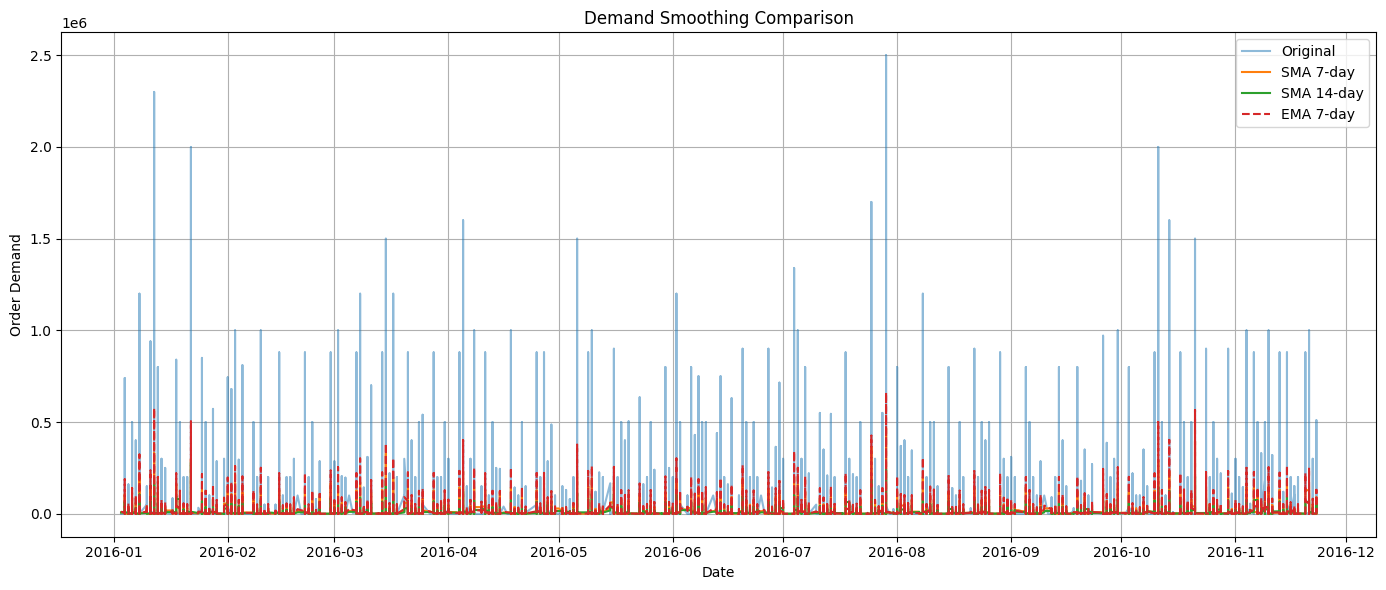

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Order_Demand'], label='Original', alpha=0.5)
plt.plot(df['Date'], df['sma_7'], label='SMA 7-day')
plt.plot(df['Date'], df['sma_14'], label='SMA 14-day')
plt.plot(df['Date'], df['ema_7'], label='EMA 7-day', linestyle='--')
plt.legend()
plt.title('Demand Smoothing Comparison')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
df = df.dropna(subset=['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14'])

In [59]:
print(df[['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14']].isnull().sum())

lag_1             0
rolling_mean_3    0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
sma_14            0
dtype: int64


In [61]:
ts = df['Order_Demand']  # replace with your actual column name

# Train-test split (80% train, 20% test)
split_index = int(len(ts) * 0.8)
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

In [62]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=14.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3187868.885, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3187237.128, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3187284.156, Time=1.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3187022.579, Time=1.00 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3186875.571, Time=1.23 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3186785.103, Time=1.96 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3186671.118, Time=2.24 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=57.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=56.45 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3183778.917, Time=6.91 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3183784.517, Time=5.71 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3183780.917, Time=52.70 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3183786.517, Time=34.79 sec

Best mode

In [16]:
model = ARIMA(train, order=stepwise_model.order) # (p,d,q) — adjust as needed
model_fit = model.fit()

# Forecast for the test set
forecast = model_fit.forecast(steps=len(test))

d:\ML\Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ML\Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ML\Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ML\Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\ML\Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in

In [18]:
r2 = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: -0.05259591667143315
RMSE: 2.986942864949781


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


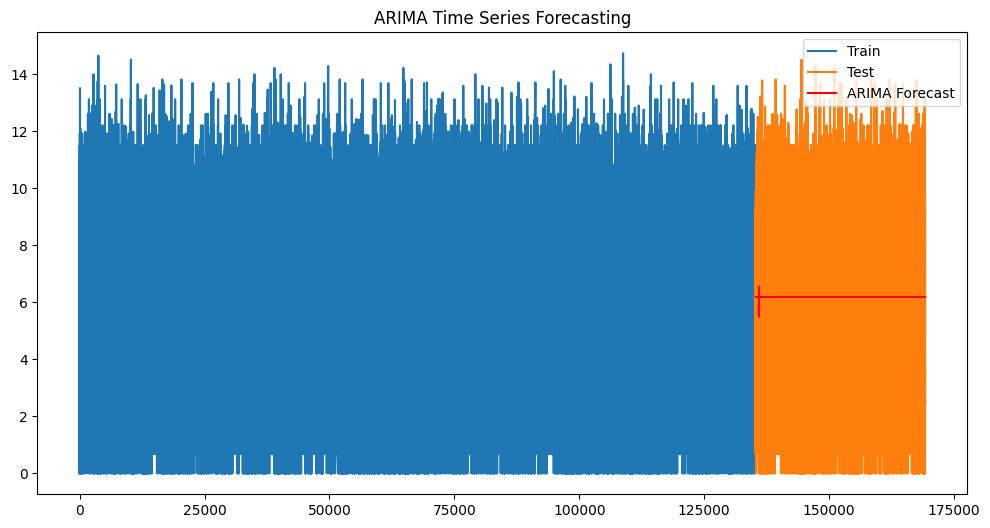

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title("ARIMA Time Series Forecasting")
plt.legend()
plt.show()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['prev_day_demand'] = df['Order_Demand'].shift(1)
df['rolling_avg_7'] = df['Order_Demand'].rolling(window=7).mean()


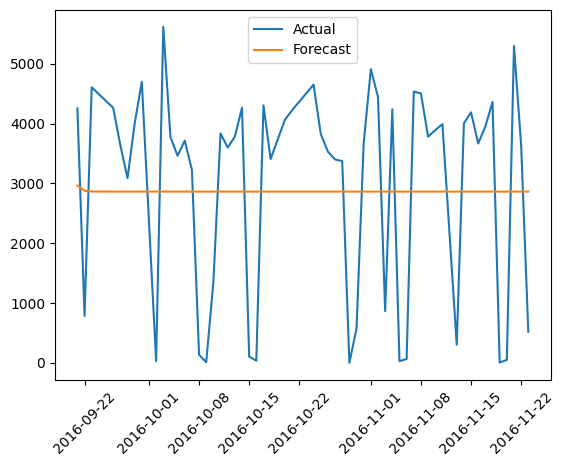

In [20]:
df['Date'] = pd.to_datetime(df['Date'])  # if not already
df['Order_Demand'] = df['Order_Demand'].astype(int)  # clean quantity column

# Group total demand by date
daily_demand = df.groupby('Date')['Order_Demand'].sum().reset_index()

# Now apply ARIMA to total demand
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

model = ARIMA(train['Order_Demand'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs forecast
import matplotlib.pyplot as plt
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [21]:
from pmdarima import auto_arima

# assume `daily_demand` is your time series DataFrame
stepwise_model = auto_arima(train['Order_Demand'], 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4399.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4177.184, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4285.608, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4160.100, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4145.181, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4139.067, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4135.412, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4054.054, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4060.574, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4052.488, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4061.825, Time=0.08 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=4064.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  231
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -1995.959
Date:                Wed, 23 Jul 2025   AIC                           4015.919
Time:                        19:37:42   BIC                           4057.228
Sample:                             0   HQIC                          4032.580
                                - 231                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4394.5873   3770.716      1.165      0.244   -2995.880    1.18e+04
ar.L1          0.4285      0.478      0.896      0.370      -0.508       1.366
ar.L2         -0.8991      0.078    -11.580      0.000      -1.051      -0.747
ar.L3          0.4257      0.450      0.946      0.344      -0.457       1.308
ar.L4         -0.8533      0.064    -13.326      0.000      -0.979      -0.728
ar.L5          0.3799      0.419      0.908      0.364      -0.440       1.200
ma.L1         -0.2861      0.455     -0.629      0.529      -1.177       0.605
ma.L2          0.7589      0.115      6.600      0.000       0.534       0.984
ma.L3         -0.3111      0.406     -0.766      0.444      -1.107       0.485
ma.L4          0.5783      0.110      5.237      0.000       0.362       0.795
ma.L5         -0.4294      0.300     -1.433      0.152      -1.017       0.158
sigma2      1.941e+06   2.39e+05      8.122      0.000    1.47e+06    2.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.51   Prob(JB):                         0.35
Heteroskedasticity (H):               1.21   Skew:                            -0.12
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
forecast = stepwise_model.predict(n_periods=len(test))

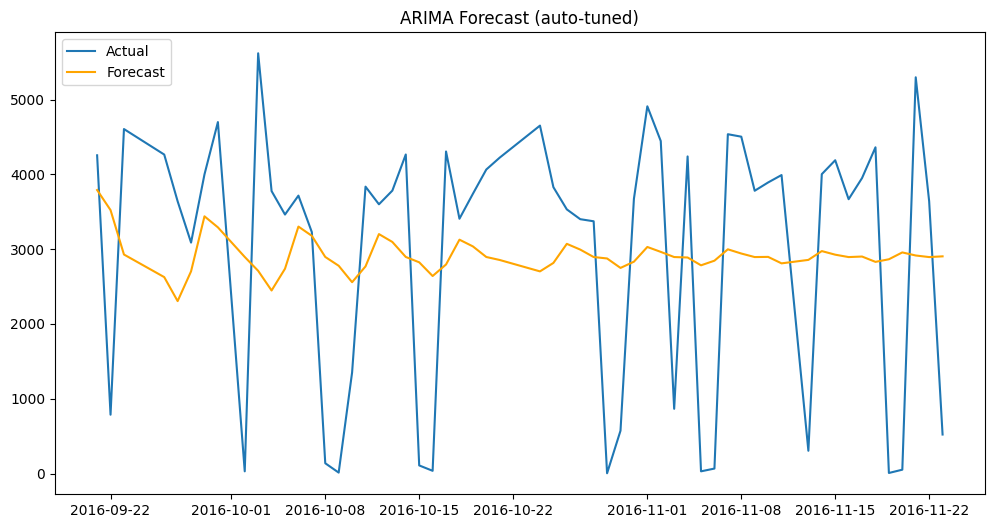

In [23]:
plt.figure(figsize=(12,6))
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast', color='orange')
plt.title('ARIMA Forecast (auto-tuned)')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4055.719, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4070.426, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4070.430, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4069.100, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4399.551, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4074.272, Time=0.55 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4074.363, Time=0.35 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=4053.824, Time=0.44 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4075.333, Time=0.46 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=4055.012, Time=0.96 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4054.083, Time=0.45 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=4072.666, Time=0.64 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=4074.491, Time=0.39 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=4056.503, Time=1.78 sec
 ARIMA(2,0,3)(2,0,1)[7] intercept

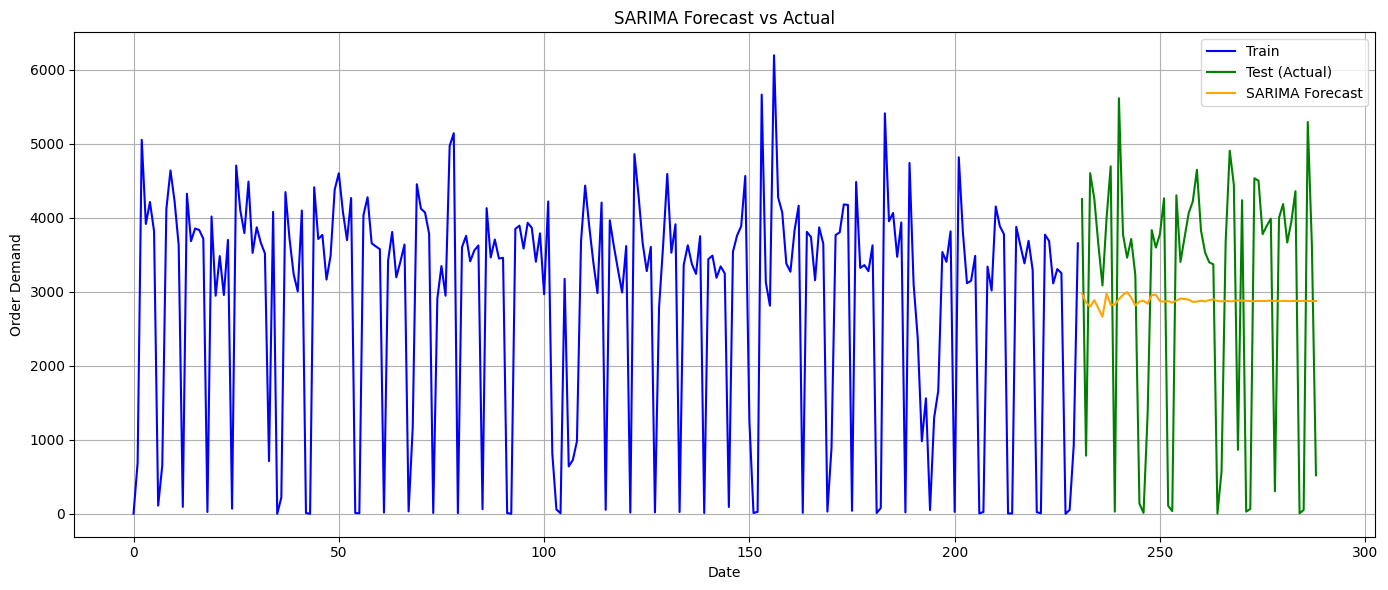

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Train SARIMA
sarima_model = auto_arima(train['Order_Demand'],
                          seasonal=True,
                          m=7,  # Weekly seasonality
                          trace=True,
                          stepwise=True,
                          suppress_warnings=True)

# Forecast on test set
sarima_forecast = sarima_model.predict(n_periods=len(test))

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Order_Demand'], label='Train', color='blue')
plt.plot(test.index, test['Order_Demand'], label='Test (Actual)', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# Convert date column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and sum Order_Demand
df_daily = df.groupby('Date').agg({'Order_Demand': 'sum'}).reset_index()

# Rename for Prophet
df_daily = df_daily.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})


In [26]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(df_daily)

d:\ML\Forecast\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:38:25 - cmdstanpy - INFO - Chain [1] start processing
19:38:26 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = model.make_future_dataframe(periods=30)  # predict 30 days into future
forecast = model.predict(future)

d:\ML\Forecast\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\ML\Forecast\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
d:\ML\Forecast\venv\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the 

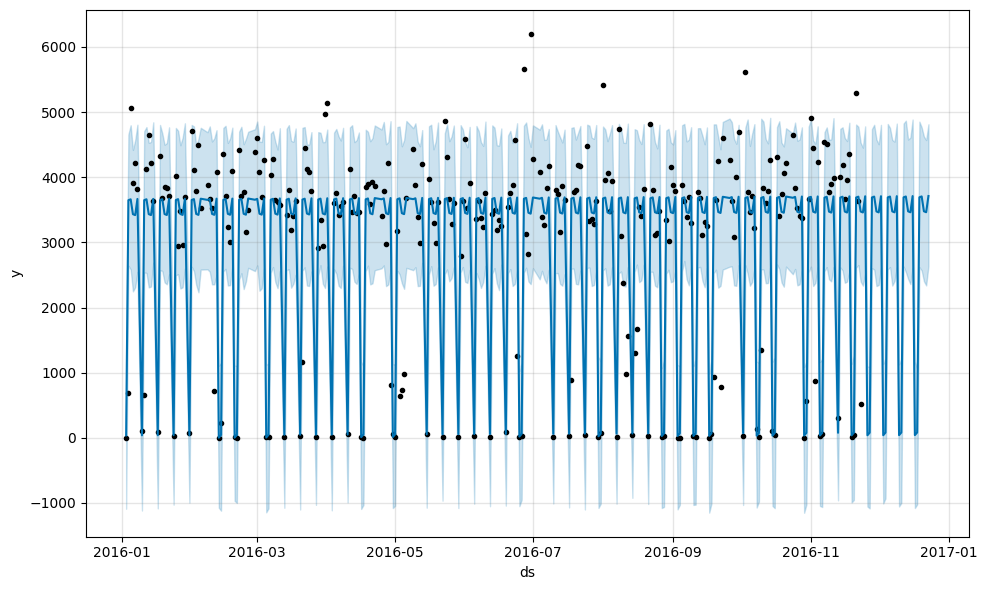

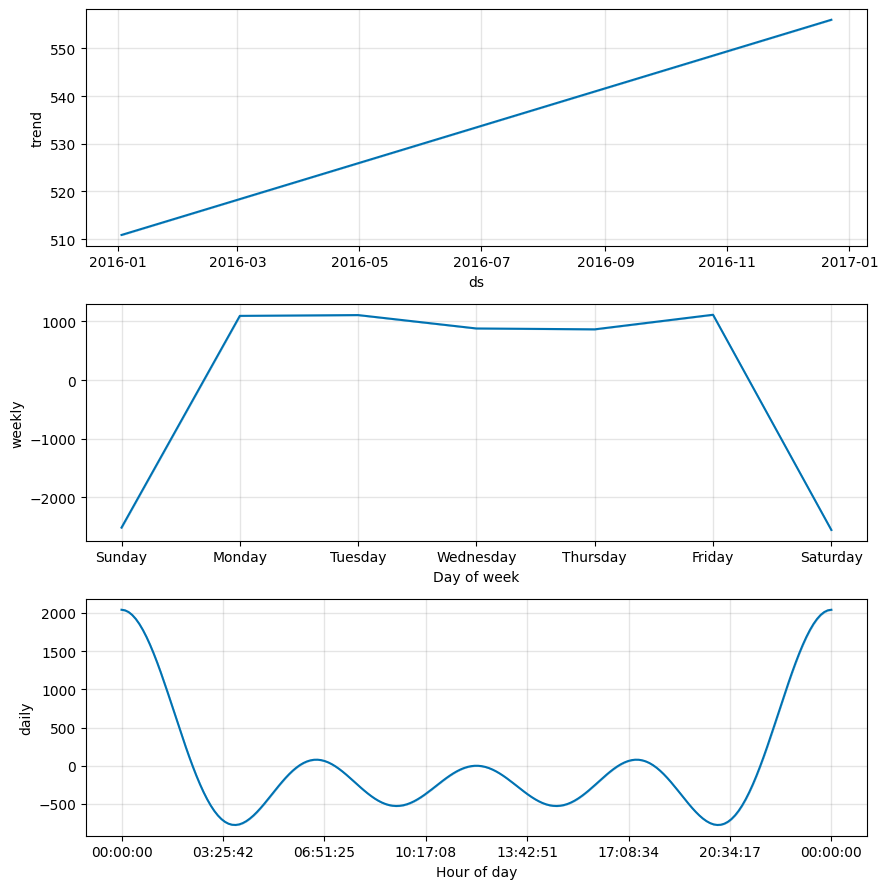

In [28]:
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Only use historical part for evaluation
merged = pd.merge(df_daily, forecast[['ds', 'yhat']], on='ds')

rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
r2 = r2_score(merged['y'], merged['yhat'])

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 844.0996438412894
R² Score: 0.7337787653572767


In [30]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='180 days', period='15 days', horizon='30 days', parallel="processes")
df_p = performance_metrics(df_cv)

print(df_p.columns)

Index(['horizon', 'mse', 'rmse', 'mae', 'mdape', 'smape', 'coverage'], dtype='object')


In [31]:
from sklearn.metrics import r2_score

# yhat is the prediction, y is the actual
r2 = r2_score(df_cv['y'], df_cv['yhat'])
print("Manual R² Score:", r2)


Manual R² Score: 0.7273139658968643


In [32]:
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation

param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_r2 = -1
best_params = None

for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        for sm in param_grid['seasonality_mode']:
            model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode=sm
            )
            model.fit(df_daily)

            df_cv = cross_validation(model, initial='180 days', period='15 days', horizon='30 days', parallel="processes")
            r2 = r2_score(df_cv['y'], df_cv['yhat'])

            print(f"Params: cps={cps}, sps={sps}, sm={sm} → R²: {r2:.4f}")

            if r2 > best_r2:
                best_r2 = r2
                best_params = {'cps': cps, 'sps': sps, 'sm': sm}


19:39:32 - cmdstanpy - INFO - Chain [1] start processing
19:39:32 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=5.0, sm=additive → R²: 0.7299


19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=5.0, sm=multiplicative → R²: 0.7238


19:39:40 - cmdstanpy - INFO - Chain [1] start processing
19:39:40 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=10.0, sm=additive → R²: 0.7308


19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=10.0, sm=multiplicative → R²: 0.7229


19:39:48 - cmdstanpy - INFO - Chain [1] start processing
19:39:48 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=20.0, sm=additive → R²: 0.7293


19:39:52 - cmdstanpy - INFO - Chain [1] start processing
19:39:52 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.01, sps=20.0, sm=multiplicative → R²: 0.7245


19:39:56 - cmdstanpy - INFO - Chain [1] start processing
19:39:56 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=5.0, sm=additive → R²: 0.7255


19:40:00 - cmdstanpy - INFO - Chain [1] start processing
19:40:00 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=5.0, sm=multiplicative → R²: 0.7273


19:40:04 - cmdstanpy - INFO - Chain [1] start processing
19:40:04 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=10.0, sm=additive → R²: 0.7271


19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=10.0, sm=multiplicative → R²: 0.7268


19:40:13 - cmdstanpy - INFO - Chain [1] start processing
19:40:14 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=20.0, sm=additive → R²: 0.7284


19:40:18 - cmdstanpy - INFO - Chain [1] start processing
19:40:18 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.05, sps=20.0, sm=multiplicative → R²: 0.7271


19:40:23 - cmdstanpy - INFO - Chain [1] start processing
19:40:24 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=5.0, sm=additive → R²: 0.7273


19:40:29 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=5.0, sm=multiplicative → R²: 0.7229


19:40:35 - cmdstanpy - INFO - Chain [1] start processing
19:40:35 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=10.0, sm=additive → R²: 0.7260


19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=10.0, sm=multiplicative → R²: 0.7233


19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=20.0, sm=additive → R²: 0.7269


19:40:52 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing


Params: cps=0.1, sps=20.0, sm=multiplicative → R²: 0.7223


In [33]:
model = Prophet()

# Add regressors
model.add_regressor('Open')
model.add_regressor('Promo')
model.add_regressor('StateHoliday')
model.add_regressor('SchoolHoliday')
model.add_regressor('Petrol_price')

In [34]:
df_daily.columns

Index(['ds', 'y'], dtype='object')

In [35]:
from prophet import Prophet

model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(df_daily)


19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score

# 1. Perform cross-validation
df_cv = cross_validation(
    model,
    initial='210 days',
    period='30 days',
    horizon='60 days'
)

# 2. Get metrics
df_perf = performance_metrics(df_cv)

# 3. Manually calculate R² using true vs predicted
r2 = r2_score(df_cv['y'], df_cv['yhat'])
print(f"R² Score: {r2:.4f}")


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.46it/s]19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

R² Score: -0.5261


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169198 entries, 6 to 169210
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_id        169198 non-null  int64         
 1   Product_Code      169198 non-null  object        
 2   Warehouse         169198 non-null  object        
 3   Product_Category  169198 non-null  object        
 4   Date              169198 non-null  datetime64[ns]
 5   Order_Demand      169198 non-null  int64         
 6   Open              169198 non-null  int64         
 7   Promo             169198 non-null  int64         
 8   StateHoliday      169198 non-null  object        
 9   SchoolHoliday     169198 non-null  int64         
 10  Petrol_price      169198 non-null  int64         
 11  year              169198 non-null  int32         
 12  month             169198 non-null  int32         
 13  day               169198 non-null  int32         
 14  dayofweek

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Extract time features
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop(columns='Date', inplace=True)

# Prepare data
X = df.drop(columns=['Order_Demand'])  # drop datetime
y = df['Order_Demand']

# One-hot encode
X_full = pd.get_dummies(X, columns=['Warehouse', 'Product_Category', 'StateHoliday','Product_Code'], drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))

# Feature importance



R² Score: 0.9226113612481279


In [65]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np     

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 9282.291282289416
R2 Score: 0.9226113612481279


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


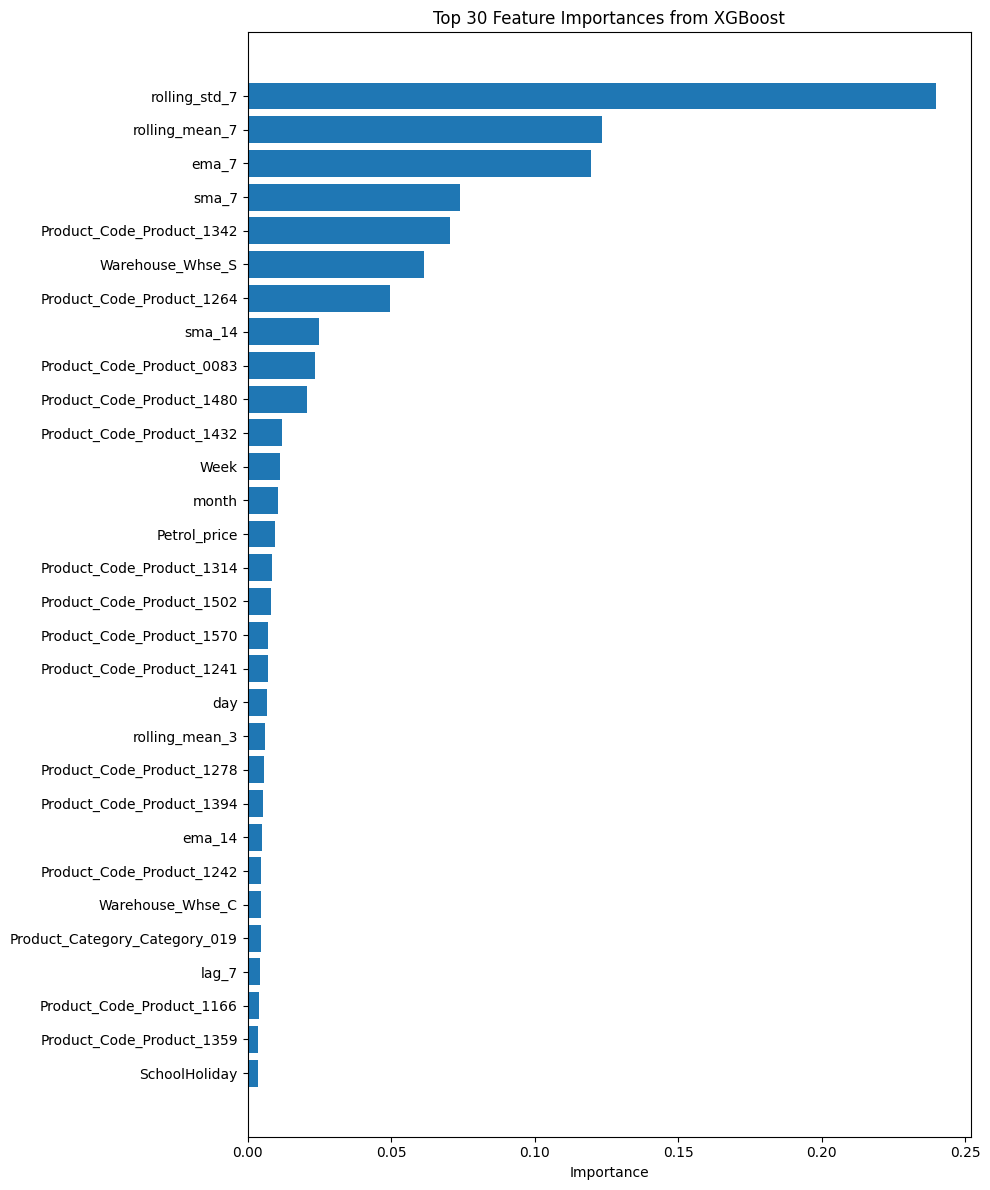

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort
importances = model.feature_importances_
feature_names = X_full.columns
indices = np.argsort(importances)[::-1]  # descending

# Choose top 30 features
top_n = 30
top_features = feature_names[indices][:top_n]
top_importances = importances[indices][:top_n]

# Plot
plt.figure(figsize=(10, 12))
plt.barh(top_features[::-1], top_importances[::-1])  # reverse for top-to-bottom
plt.title("Top 30 Feature Importances from XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [67]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

# Initialize model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=100
)

# Fit model
cat_model.fit(X_train, y_train)

# Predict and evaluate
cat_preds = cat_model.predict(X_test)
print("CatBoost R² Score:", r2_score(y_test, cat_preds))


0:	learn: 28345.6637852	total: 36ms	remaining: 35.9s
100:	learn: 6147.9905615	total: 2.51s	remaining: 22.3s
200:	learn: 4676.5221150	total: 4.81s	remaining: 19.1s
300:	learn: 3839.5755658	total: 6.8s	remaining: 15.8s
400:	learn: 3257.8293016	total: 8.81s	remaining: 13.2s
500:	learn: 2787.9221371	total: 10.9s	remaining: 10.8s
600:	learn: 2501.3600541	total: 12.9s	remaining: 8.55s
700:	learn: 2276.2143882	total: 14.9s	remaining: 6.35s
800:	learn: 2101.8249603	total: 16.9s	remaining: 4.2s
900:	learn: 1945.3348512	total: 19s	remaining: 2.08s
999:	learn: 1836.1717506	total: 21.3s	remaining: 0us
CatBoost R² Score: 0.9375558864375494


In [68]:
from lightgbm import LGBMRegressor

# Initialize model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6
)

# Fit model
lgb_model.fit(X_train, y_train)

# Predict and evaluate
lgb_preds = lgb_model.predict(X_test)
print("LightGBM R² Score:", r2_score(y_test, lgb_preds))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5432
[LightGBM] [Info] Number of data points in the train set: 135358, number of used features: 1395
[LightGBM] [Info] Start training from score 5240.728018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [69]:
import pandas as pd
import time
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# Drop 'Date'
X = df.drop(columns=['Order_Demand'])
y = df['Order_Demand']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Models to compare
models = {
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6),
    'CatBoost': CatBoostRegressor(verbose=0, n_estimators=200, learning_rate=0.1, depth=6),
    'LightGBM': LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
}

# To store results
results = []

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start_time
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'R2 Score': round(r2, 4),
        'Time (s)': round(duration, 2)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

# Show comparison
print("Model Comparison:")
print(results_df)

# Select the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")

# Cross Validation for robustness
cv_scores = cross_val_score(best_model, X_encoded, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5432
[LightGBM] [Info] Number of data points in the train set: 135358, number of used features: 1395
[LightGBM] [Info] Start training from score 5240.728018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [70]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

# Use the same config
final_model = CatBoostRegressor(verbose=0, n_estimators=200, learning_rate=0.1, depth=6)

# Perform 5-fold CV
cv_scores = cross_val_score(final_model, X_encoded, y, cv=5, scoring='r2')

# Output results
print(f"CatBoost Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

CatBoost Cross-Validation R² Scores: [0.90791974 0.95073446 0.95135395 0.91377855 0.91218273]
Mean R² Score: 0.9272
Standard Deviation: 0.0196


In [71]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 1621.5955980310341
RMSE: 8780.915176225419
R2 Score: 0.9307457570652556


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
final_model.save_model("catboost_model.cbm")

In [73]:
final_model.save_model("catboost_model.json", format="json")
final_model.save_model("catboost_model.py", format="python")

In [76]:
from catboost import CatBoostRegressor

model_90 = CatBoostRegressor(loss_function='Quantile:alpha=0.9', iterations=1000, depth=6, learning_rate=0.1, verbose=100)
model_10 = CatBoostRegressor(loss_function='Quantile:alpha=0.1', iterations=1000, depth=6, learning_rate=0.1, verbose=100)

model_90.fit(X_train, y_train)
model_10.fit(X_train, y_train)

y_pred_90 = model_90.predict(X_test)
y_pred_10 = model_10.predict(X_test)


0:	learn: 3252.6849915	total: 28ms	remaining: 28s
100:	learn: 559.5832024	total: 2.95s	remaining: 26.2s
200:	learn: 429.6034027	total: 5.96s	remaining: 23.7s
300:	learn: 397.6882697	total: 8.59s	remaining: 20s
400:	learn: 378.2581177	total: 14.1s	remaining: 21s
500:	learn: 365.5145482	total: 17.3s	remaining: 17.2s
600:	learn: 341.7847992	total: 20.2s	remaining: 13.4s
700:	learn: 332.8144173	total: 22.9s	remaining: 9.77s
800:	learn: 325.4046166	total: 25.5s	remaining: 6.33s
900:	learn: 320.4751516	total: 28.1s	remaining: 3.09s
999:	learn: 315.1116931	total: 30.6s	remaining: 0us
0:	learn: 523.0744925	total: 28.3ms	remaining: 28.2s
100:	learn: 508.4487921	total: 2.73s	remaining: 24.3s
200:	learn: 414.8500315	total: 5.31s	remaining: 21.1s
300:	learn: 364.8865579	total: 8.15s	remaining: 18.9s
400:	learn: 326.3970277	total: 10.9s	remaining: 16.2s
500:	learn: 302.3649039	total: 13.5s	remaining: 13.4s
600:	learn: 289.9580248	total: 16.1s	remaining: 10.7s
700:	learn: 271.8818498	total: 18.8s	re

In [79]:
# Combine them
df_pred = pd.DataFrame({
    'Actual': y_test,
    'Prediction': y_pred,  # From the median model
    'Lower_Bound_10%': y_pred_10,
    'Upper_Bound_90%': y_pred_90
})


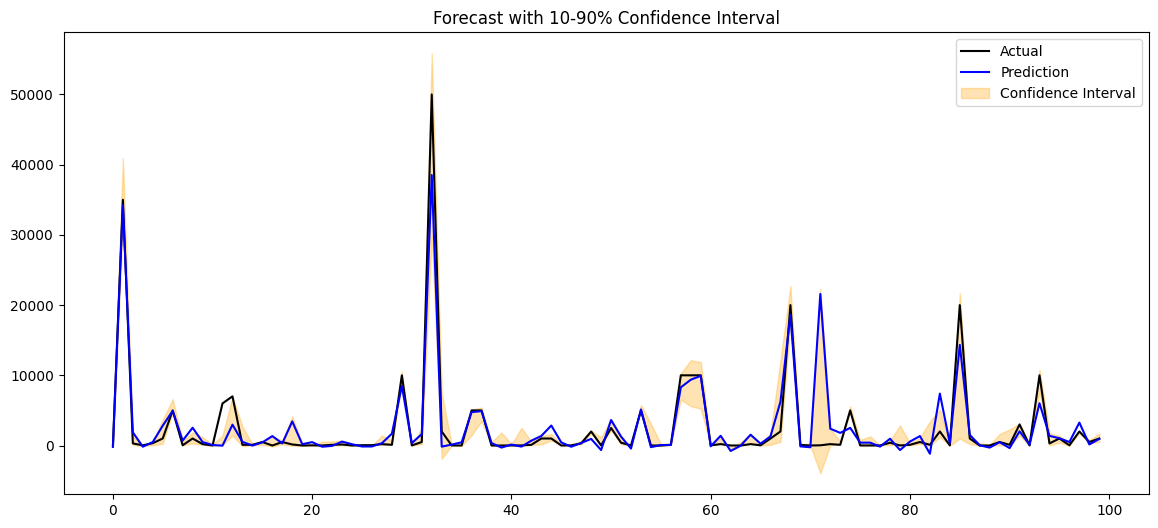

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_pred['Actual'].values[:100], label='Actual', color='black')
plt.plot(df_pred['Prediction'].values[:100], label='Prediction', color='blue')
plt.fill_between(range(100), df_pred['Lower_Bound_10%'].values[:100], df_pred['Upper_Bound_90%'].values[:100], color='orange', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title("Forecast with 10-90% Confidence Interval")
plt.show()


In [81]:
model.save_model("catboost_main_model.cbm")
model_10.save_model("catboost_model_10.cbm")
model_90.save_model("catboost_model_90.cbm")


In [82]:
print('r2', r2_score(y_test, y_pred))
print('r2 10%', r2_score(y_test, y_pred_10))
print('r2 90%', r2_score(y_test, y_pred_90))
print('rmse', mean_squared_error(y_test, y_pred, squared=False))

r2 0.9307457570652556
r2 10% 0.3340460198158809
r2 90% 0.8693181072964078
rmse 8780.915176225419


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
